In [1]:
import numpy as np
import pickle
import pandas as pd
import re
import unicodedata

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Merge player stats

In [3]:
with open('player_stats.pickle', 'rb') as handle:
    player_stats = pickle.load(handle)

In [4]:
all_seasons = []
for season_stats in player_stats:
    all_teams = []
    for team_stats in season_stats:
        team = pd.concat(team_stats, axis=1)
        all_teams.append(team)
    all_teams = pd.concat(all_teams, axis=0)
    all_seasons.append(all_teams)
all_stats = pd.concat(all_seasons)

## Clean column name

In [5]:
all_stats = all_stats.rename(columns = lambda x: re.sub(r'(Unnamed: \d_\w+_\d\s)|(\sUnnamed: \d_\w+_\d)|(\sUnnamed: \d_\w+_\d\s)', '', x))

In [6]:
all_stats = all_stats.loc[:,~all_stats.columns.duplicated()]

# Merge on off stats

In [7]:
with open('onoff_stats.pickle', 'rb') as handle:
    onoff_stats = pickle.load(handle)

In [8]:
all_seasons = []
for season_stats in onoff_stats:
    all_teams = []
    for team_stats in season_stats:
        team = pd.concat(team_stats, axis=1)
        all_teams.append(team)
    all_teams = pd.concat(all_teams, axis=0)
    all_seasons.append(all_teams)
all_stats_on_off = pd.concat(all_seasons)

## Clean column name

In [9]:
all_stats_on_off = all_stats_on_off.rename(columns = lambda x: re.sub(r'(Unnamed: \d_\w+_\d\s)|(\sUnnamed: \d_\w+_\d)|(\sUnnamed: \d_\w+_\d\s)', '', x))

In [10]:
all_stats_on_off.drop([x for x in list(all_stats_on_off.columns) if re.search(r'Unnamed', x)], axis=1, inplace=True)

In [11]:
all_stats_on_off = all_stats_on_off.loc[:,~all_stats_on_off.columns.duplicated()]

In [12]:
all_stats_on_off.shape

(9638, 103)

# Filter free agents

In [13]:
with open('free_agents.pickle', 'rb') as handle:
    free_agents = pickle.load(handle)

In [14]:
all_stats = all_stats.drop_duplicates(['Player', 'season'])

In [15]:
all_stats_on_off = all_stats_on_off.drop_duplicates(['Player', 'season'])

## Fix name asterisk

In [16]:
def fix_asterisk(string):
    return string.replace('*', '')

In [17]:
free_agents['Player'] = free_agents['Player'].apply(fix_asterisk)

## Fix name encoding before merge

In [18]:
def fix_encoding(string):
    return unicodedata.normalize('NFKD', string).encode("ascii","ignore").decode()

In [19]:
free_agents['Player'] = free_agents['Player'].apply(fix_encoding)

## Fixing dot in first name before merge

In [20]:
def fix_dot(string):
    if string.count('.') > 1:
        clean = "".join(re.findall(r'[\w]+', string))
        return clean[:2] + " " + clean[2:]
    else:
        return string

In [21]:
free_agents['Player'] = free_agents['Player'].apply(fix_dot)

## Check name again

In [22]:
free_agents.loc[free_agents['Player'].apply(lambda x: True if not re.search('[^\x00-\x7F]', x) else False)]

,Player,previous season
0,Alan Henderson,2004-05
1,Alejandro Sanchez,2004-05
2,Alex Garcia,2004-05
3,Anthony Carter,2004-05
4,Antonio Daniels,2004-05
...,...,...
289,Yves Pons,2020-21
290,Zach Collins,2020-21
291,Zavier Simpson,2020-21
292,Zylan Cheatham,2020-21


## Merge

In [23]:
free_agents_stats = free_agents.merge(all_stats, how='left',
            left_on=['Player', 'previous season'],
            right_on=['Player', 'season']).merge(all_stats_on_off, how='left',
                                                left_on=['Player', 'previous season'],
                                                right_on=['Player', 'season'])

In [24]:
free_agents_stats.info('memory_usage'=='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Columns: 188 entries, Player to Opponent Shot Frequency AllThree #
dtypes: float64(113), object(75)
memory usage: 4.5+ MB


# Data Cleaning

In [25]:
import seaborn as sns

In [26]:
columns = free_agents_stats.columns

In [27]:
free_agents_stats.shape[0]

3129

In [28]:
columns_to_drop = []
for c in columns:
    if free_agents_stats[c].isnull().sum() == free_agents_stats.shape[0]:
        columns_to_drop.append(c)

In [29]:
free_agents_stats.drop(columns=columns_to_drop, inplace=True)

In [30]:
free_agents_stats.drop([c for c in free_agents_stats if c[-1] == '%'], axis=1, inplace=True)

free_agents_stats.drop(columns=['MIN_y', 'id_y', 'season_y'], inplace=True)

free_agents_stats.rename({'MIN_x': 'MIN', 'id_x': 'id', 'season_x': 'season',
                          'eFG% %_x': 'Player eFG% %', 'eFG% #_x': 'Player eFG% #',
                          'eFG% %_y': 'Team eFG% %', 'eFG% #_y': 'Team eFG% #'}, axis=1, inplace=True)

<AxesSubplot:>

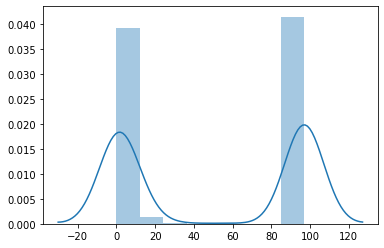

In [31]:
sns.distplot(a=free_agents_stats.apply(pd.Series.isnull, axis=0).apply(pd.Series.sum, axis=1).values)

In [32]:
free_agents_stats = free_agents_stats.loc[~free_agents_stats.apply(pd.Series.isnull, axis=0).apply(pd.Series.sum, axis=1).apply(lambda x: x >= free_agents_stats.shape[1]/3), :]

In [33]:
free_agents_stats = free_agents_stats.fillna(free_agents_stats.mean())

<ipython-input-33-67b8095275f4>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  free_agents_stats = free_agents_stats.fillna(free_agents_stats.mean())


In [34]:
free_agents_stats.fillna(0, inplace=True)

# Merge salary

In [35]:
free_agents_stats['Next season'] = free_agents_stats['season'].apply(lambda x: str(int(x[:4])+1) + "-" + str(int(x[:4])+2)[2:])

In [36]:
with open("player_salaries.pickle", 'rb') as handle:
    player_salaries = pickle.load(handle)

In [37]:
stats_salaries = free_agents_stats.merge(player_salaries, how='left',
                        left_on=['Player', 'Next season'], right_on=['Player', 'season'])

In [38]:
stats_salaries = stats_salaries.loc[~stats_salaries['Salary'].isnull()]

In [39]:
stats_salaries.drop(columns=['season_x', 'season_y'], inplace=True)

# Merge salary cap

In [40]:
salary_caps = pd.read_excel('salary_caps.xlsx')

In [41]:
salary_caps = salary_caps[['season', 'salary_cap']]

In [42]:
stats_salaries_cap = stats_salaries.merge(salary_caps,
                                         how='left', left_on='Next season', right_on='season')

In [43]:
stats_salaries_cap.drop(columns=['season'], inplace=True)

In [44]:
stats_salaries_cap['Salary'].isnull().sum()

0

In [45]:
stats_salaries_cap['cap_usage'] = stats_salaries_cap['Salary'] / stats_salaries_cap['salary_cap']

# Percentage into float

In [46]:
def p2f(x):
    if 0:
        return float(0)
    return float(x.strip('%'))/100

In [47]:
for c in stats_salaries_cap.columns:
    if '#' in c:
        stats_salaries_cap[c] = stats_salaries_cap[c].apply(lambda x: float(str(x).strip('%'))/100)

In [48]:
stats_salaries_cap.drop(columns=['MIN'], inplace=True)

# Merge with BBR basic and advanced stats

In [49]:
bbr_advanced = pd.read_csv("advanced.csv")

In [50]:
bbr_advanced['name'] = bbr_advanced['name'].apply(fix_encoding).apply(fix_dot)

In [51]:
bbr_advanced.drop(columns=['Unnamed: 0', 'positions', 'age', 'team', 'games_played', 'minutes_played', 'is_combined_totals', 'slug'], inplace=True)

In [52]:
bbr_advanced = bbr_advanced.loc[~bbr_advanced.duplicated(['name', 'season'])]

In [53]:
stats_salaries_cap = stats_salaries_cap.merge(bbr_advanced, how='left',
                         left_on=['Player', 'previous season'],
                         right_on=['name', 'season'])

# Merge Raptor Data from 538

In [55]:
historical = pd.read_csv('historical_RAPTOR_by_player.csv')

In [56]:
modern = pd.read_csv('modern_RAPTOR_by_player.csv')

In [57]:
historical.columns

Index(['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_offense',
       'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season',
       'war_playoffs', 'predator_offense', 'predator_defense',
       'predator_total', 'pace_impact'],
      dtype='object')

In [58]:
historical['season'] = historical['season'].apply(lambda x: str(x-1) + "-" + str(x)[2:])

In [59]:
stats_salaries_cap = stats_salaries_cap.merge(historical, how='left', left_on=['Player', 'previous season'], right_on=['player_name', 'season'])

In [60]:
stats_salaries_cap = stats_salaries_cap.loc[~stats_salaries_cap['player_name'].isnull()]

In [62]:
stats_salaries_cap.drop(columns=['player_id', 'player_name', 'mp', 'id', 'name'], inplace=True)

In [63]:
for c in stats_salaries_cap.columns:
    if stats_salaries_cap[c].isnull().sum() != 0:
        print(c)

player_efficiency_rating
true_shooting_percentage
three_point_attempt_rate
free_throw_attempt_rate
offensive_rebound_percentage
defensive_rebound_percentage
total_rebound_percentage
assist_percentage
steal_percentage
block_percentage
turnover_percentage
usage_percentage
offensive_win_shares
defensive_win_shares
win_shares
win_shares_per_48_minutes
offensive_box_plus_minus
defensive_box_plus_minus
box_plus_minus
value_over_replacement_player
season_x


In [65]:
stats_salaries_cap.loc[stats_salaries_cap['player_efficiency_rating'].isnull()]

,Player,previous season,Age,Pos,GP,GS,MPG,Usage #,PSA #,AST% #,AST:Usg #,TOV% #,Player eFG% %,Player eFG% #,2P% #,3P% #,FT% #,ASTD%All #,ASTD%Rim #,ASTD%Mid #,ASTD%Three #,% of Shot Attempts Rim #,% of Shot Attempts Short Mid #,% of Shot Attempts Long Mid #,% of Shot Attempts Midrange #,% of Shot Attempts Corner #,% of Shot Attempts Non-Corner #,% of Shot Attempts Three #,FG% Rim #,FG% Short Mid #,FG% Long Mid #,FG% Midrange #,FG% Corner #,FG% Non-Corner #,FG% Three #,SFLD% #,FFLD% #,AND1% #,BLK% #,STL% #,FOUL% #,fgOR% #,fgDR% #,ftOR% #,ftDR% #,Diff #,Exp W,Offense Pts/Poss #,Offense eFG% #,Offense TOV% #,...,Off Steals Pts+/Poss #,Off Steals Freq #,Off Steals Pts/Play #,Off Live Rebounds Pts+/Poss #,Off Live Rebounds Freq #,Off Live Rebounds Pts/Play #,Opponent Shot Frequency Rim #,Opponent Shot Frequency ShortMid #,Opponent Shot Frequency LongMid #,Opponent Shot Frequency AllMid #,Opponent Shot Frequency CornerThree #,Opponent Shot Frequency NonCorner #,Opponent Shot Frequency AllThree #,Next season,Salary,salary_cap,cap_usage,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,season_x,season_y,poss,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
1299,Wes Iwundu,2020-21,25.9,Forward,16.0,3.0,14.3,0.081,0.722,0.051,0.0062,0.12,0.0,0.303,0.438,0.118,1.0,0.89,1.0,0.0,1.0,0.4,0.09,0.03,0.11,0.31,0.17,0.49,0.5,0.33,0.0,0.25,0.09,0.17,0.12,0.057,0.01,0.0,0.002,0.014,0.039,0.026,0.118,0.0,0.118,-0.144,-32.0,-0.088,-0.029,0.012,...,-0.001,0.043,-0.062,0.002,-0.012,0.078,0.039,-0.021,0.006,-0.015,-0.014,-0.01,-0.024,2021-22,1824003.0,125000000,0.014592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-21,1155.0,-5.452238,-0.475145,-5.927382,-0.870063,-0.870063,0.0,-5.595269,-1.53796,-7.133229,0.016834


In [66]:
stats_salaries_cap = stats_salaries_cap.loc[~stats_salaries_cap['player_efficiency_rating'].isnull()]

# Incorporate salary categories

In [67]:
with open('salary_categories_dict.pickle', 'rb') as handle:
    salary_categories_dict = pickle.load(handle)

In [68]:
def assign_category(row, index='Salary'):
    season_dict = salary_categories_dict[row['Next season']]
    sorted_season_dict = dict(sorted(season_dict.items(), key=lambda item: abs(item[0] - row[index])))
    return list(sorted_season_dict.values())[0]

In [69]:
stats_salaries_cap['salary_category'] = stats_salaries_cap.apply(assign_category, axis=1)

<ipython-input-69-a9adaf49b37f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_salaries_cap['salary_category'] = stats_salaries_cap.apply(assign_category, axis=1)


In [72]:
stats_salaries_cap = stats_salaries_cap.loc[~stats_salaries_cap.duplicated(['Player', 'previous season'])]

In [73]:
stats_salaries_cap

,Player,previous season,Age,Pos,GP,GS,MPG,Usage #,PSA #,AST% #,AST:Usg #,TOV% #,Player eFG% %,Player eFG% #,2P% #,3P% #,FT% #,ASTD%All #,ASTD%Rim #,ASTD%Mid #,ASTD%Three #,% of Shot Attempts Rim #,% of Shot Attempts Short Mid #,% of Shot Attempts Long Mid #,% of Shot Attempts Midrange #,% of Shot Attempts Corner #,% of Shot Attempts Non-Corner #,% of Shot Attempts Three #,FG% Rim #,FG% Short Mid #,FG% Long Mid #,FG% Midrange #,FG% Corner #,FG% Non-Corner #,FG% Three #,SFLD% #,FFLD% #,AND1% #,BLK% #,STL% #,FOUL% #,fgOR% #,fgDR% #,ftOR% #,ftDR% #,Diff #,Exp W,Offense Pts/Poss #,Offense eFG% #,Offense TOV% #,...,Off Steals Freq #,Off Steals Pts/Play #,Off Live Rebounds Pts+/Poss #,Off Live Rebounds Freq #,Off Live Rebounds Pts/Play #,Opponent Shot Frequency Rim #,Opponent Shot Frequency ShortMid #,Opponent Shot Frequency LongMid #,Opponent Shot Frequency AllMid #,Opponent Shot Frequency CornerThree #,Opponent Shot Frequency NonCorner #,Opponent Shot Frequency AllThree #,Next season,Salary,salary_cap,cap_usage,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,season_x,season_y,poss,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact,salary_category
0,Alan Henderson,2004-05,31.9,Big,78.0,10.0,14.5,0.105,1.060,0.029,0.0028,0.179,78.000000,0.523,0.523,0.000,0.534,0.53,0.53,0.52,0.00,0.69,0.26,0.05,0.31,0.00,0.00,0.00,0.61,0.33,0.40,0.34,0.00,0.00,0.00,0.000,0.000,0.000,0.015,0.011,0.054,0.142,0.148,0.000,0.189,-0.180,-42.0,-0.138,-0.063,0.026,...,0.028,-0.223000,-0.013,0.024,-0.119,0.001,0.024,0.000,0.024,-0.009,-0.017,-0.026,2005-06,719373.0,49500000,0.014533,12.4,0.539,0.009,0.345,15.6,16.8,16.2,2.6,1.2,2.3,16.2,11.3,1.5,1.5,3.1,0.122,-1.1,-0.3,-1.4,0.2,2004-05,2004-05,2529.0,-2.285736,-1.081710,-3.367447,-0.409406,-0.332792,-0.076614,-2.403432,-1.418039,-3.821471,-0.283696,2 MIN
1,Anthony Carter,2004-05,29.4,Point,64.0,12.0,10.5,0.206,0.894,0.356,0.0172,0.188,13.000000,0.392,0.405,0.200,0.694,0.58,0.47,0.67,1.00,0.34,0.06,0.54,0.60,0.01,0.04,0.06,0.56,0.30,0.32,0.32,0.00,0.14,0.11,0.000,0.000,0.000,0.014,0.023,0.057,0.019,0.083,0.000,0.000,0.001,1.0,-0.041,-0.020,0.011,...,0.029,-0.037000,-0.004,0.010,-0.042,-0.009,0.009,0.010,0.019,-0.003,-0.007,-0.011,2005-06,965185.0,49500000,0.019499,11.3,0.454,0.096,0.288,1.9,8.4,5.3,32.2,2.5,1.7,23.7,16.4,-0.3,0.8,0.5,0.034,-2.8,1.0,-1.8,0.0,2004-05,2004-05,1393.0,-2.268038,0.681246,-1.586792,0.442252,0.442252,0.000000,-2.254974,0.355168,-1.899806,0.396806,7 MIN
2,Antonio Daniels,2004-05,29.6,Combo,75.0,2.0,26.6,0.214,1.125,0.263,0.0123,0.083,74.000000,0.484,0.487,0.318,0.815,0.31,0.22,0.23,0.69,0.26,0.19,0.30,0.48,0.03,0.22,0.25,0.61,0.44,0.41,0.42,0.52,0.29,0.32,0.000,0.000,0.000,0.001,0.011,0.017,0.010,0.084,0.017,0.007,0.045,11.0,0.051,0.012,-0.003,...,-0.031,-0.044000,0.004,-0.030,0.108,0.003,0.006,-0.050,-0.044,0.013,0.027,0.040,2005-06,5000000.0,49500000,0.101010,18.0,0.557,0.265,0.488,1.2,9.0,5.1,25.6,1.4,0.1,9.3,19.0,6.3,0.5,6.8,0.160,3.0,-0.8,2.2,2.2,2004-05,2004-05,4372.0,3.386548,-1.095455,2.291094,6.054268,4.593421,1.460847,2.942028,-1.501624,1.440405,-0.688532,Room MLE
3,Awvee Storey,2004-05,27.5,Wing,9.0,0.0,2.5,0.186,0.625,0.111,0.0060,0.000,52.943071,0.312,0.167,0.500,0.000,0.50,0.00,0.00,1.00,0.25,0.00,0.50,0.50,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.50,0.00,0.50,0.000,0.000,0.000,0.000,0.000,0.047,0.040,0.048,0.500,0.000,-0.488,-20.0,-0.243,-0.116,-0.099,...,0.000,-0.012831,0.041,0.069,0.574,0.048,-0.086,0.046,-0.040,0.007,-0.015,-0.008,2005-06,641748.0,49500000,0.012965,6.9,0.368,0.200,0.200,14.8,3

In [74]:
with open('stats_salaries_cap.pickle', 'wb') as handle:
    pickle.dump(stats_salaries_cap, handle)